# ResNet-50 usando PyTorch Lightning
## Objetivos

- Importar un modelo CNN complejo
- Entrenar el modelo para clasificacion de imagenes


## Instalar e importar bibliotecas


In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch.optim as optim
from torchmetrics import Accuracy
from torchvision import datasets, transforms, models

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
import torchmetrics

from torchvision.models import resnet50, ResNet50_Weights 
from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar


In [2]:
# Configurar precisión para Tensor Cores
if torch.cuda.is_available():
    torch.set_float32_matmul_precision('high')

BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 0.001
NUM_WORKERS = 4
CLASES = 10
DATASET_PATH = './data'

In [3]:
DEBUG_MODE = True  # True Debug, False Full
 
if DEBUG_MODE:
    BATCH_SIZE = 16
    NUM_EPOCHS = 2
    print("Modo depuración activado: usando dataset ligero y parámetros reducidos.")
else:
    BATCH_SIZE = 32
    NUM_EPOCHS = 50
    print("Modo completo activado: usando configuración completa.")
 

Modo depuración activado: usando dataset ligero y parámetros reducidos.


## Preparación de la base de datos:

### Fashion MNIST contiene 60k RGB imágenes de 32x32x3 pixeles distribuidas en 10 clases.

*   Grupo de entrenamiento: 50K imágenes
*   Grupo de evaluación: 10k imágenes

In [4]:
# Descargamos dataset
 
train_dataset = torchvision.datasets.FashionMNIST(
    root=DATASET_PATH, train=True, transform=transforms.ToTensor(), download=True)

test_dataset = datasets.FashionMNIST(
    root=DATASET_PATH, train=False, transform=transforms.ToTensor(), download=True)

In [5]:
# Definimos dataloaders para los datasets

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False, # ignora el último batch si el número de muestras no son divisibles para el tamaño de batch
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=False,
                          shuffle=False)

In [6]:
print("Número de muestras de entrenamiento:", len(train_dataset))
print("Número de muestras de evaluación:", len(test_dataset))


Número de muestras de entrenamiento: 60000
Número de muestras de evaluación: 10000


In [7]:
print("Número de iteraciones por época:", len(train_loader))
# 1563*32 = 50000
# 3152*16 = 50000

Número de iteraciones por época: 3750


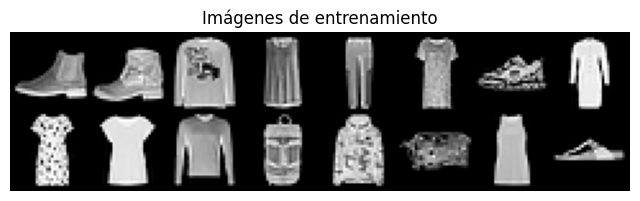

In [8]:
# Visualización de imágenes

for images, labels in train_loader:
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Imágenes de entrenamiento")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

In [9]:
# Dimensión de cada imagen
print("Dimensión de entrada:", images.shape) # (batch_size, channels_in, W, H)

Dimensión de entrada: torch.Size([16, 1, 28, 28])


In [10]:
class FMINST_DataModule(pl.LightningDataModule):
    def __init__(self, data_path="./"):
        super().__init__()
        self.data_path = data_path

        # Definir transformaciones aquí para que estén disponibles en cualquier momento
        self.train_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.GaussianBlur(kernel_size=3),
            torchvision.transforms.RandomHorizontalFlip(p=0.30),
            torchvision.transforms.RandomVerticalFlip(p=0.30),
            torchvision.transforms.RandomRotation(30),
            torchvision.transforms.Resize((256, 256)),
            torchvision.transforms.RandomCrop((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485]*3, std=[0.229]*3)])

        self.test_transform = torchvision.transforms.Compose([
            torchvision.transforms.Grayscale(num_output_channels=3),
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485]*3, std=[0.229]*3)])
               
    def prepare_data(self):
        # Este método puede quedar vacío si no se necesita descargar datos adicionales
        pass

    def setup(self, stage=None):   # cargamos el dataset
        train = datasets.FashionMNIST(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False,
        )

        self.test = datasets.FashionMNIST(
            root=self.data_path,
            train=False, # False para obtener el grupo de test
            transform=self.test_transform,
            download=False,
        )

        # Dividir el grupo de entrenamiento original en entrenamiento y validación

        self.train, self.valid = random_split(train, lengths=[int(len(train)*0.9), int(len(train)*0.1)])
        if DEBUG_MODE:
            print("DEBUG: Forzando el tamaño del conjunto de datos en setup.")
            self.train = torch.utils.data.Subset(self.train, range(5000))
            self.valid = torch.utils.data.Subset(self.valid, range(1000))


        print("Muestras de entrenamiento:", len(self.train))
        print("Muestras de validación:", len(self.valid))
        print("Muestras de evaluación:", len(self.test))

    def train_dataloader(self):
        train_loader = DataLoader(
            dataset=self.train,
            batch_size=BATCH_SIZE,
            drop_last=True,
            shuffle=True,
            num_workers=NUM_WORKERS,
        )
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(
            dataset=self.valid,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(
            dataset=self.test,
            batch_size=BATCH_SIZE,
            drop_last=False,
            shuffle=False,
            num_workers=NUM_WORKERS,
        )
        return test_loader

In [11]:
# Inicizalización de DataModule

torch.manual_seed(47)  # especificamos un random seed para reproducibilidad de inicializaciones aleatorias
data_module = FMINST_DataModule(data_path=DATASET_PATH)

In [12]:
class ResNet50TransferLearning(pl.LightningModule):
    def __init__(self, num_classes=10, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
 
        # Cargar ResNet50 con pesos preentrenados
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
 
        # Modificar la primera capa y la capa final
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.fc.parameters():
            param.requires_grad = True
 
        # Loss and metric
        self.criterion = nn.CrossEntropyLoss()
        self.train_acc = Accuracy(num_classes = num_classes, task='multiclass')
        self.valid_acc = Accuracy(num_classes = num_classes, task='multiclass')
        self.test_acc = Accuracy(num_classes = num_classes, task='multiclass')
 
    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = logits.argmax(1)
        return loss, y, preds
    
    def training_step(self, batch, batch_idx):
        loss, y, pred = self._shared_step(batch)
        self.log('train_loss', loss, on_step=False, on_epoch=True)

        # Do another forward pass in .eval() mode to compute accuracy
        # while accounting for Dropout, BatchNorm etc. behavior
        # during evaluation (inference)
        self.model.eval()
        with torch.no_grad():
            _, y, pred = self._shared_step(batch)
        self.train_acc(pred, y)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss
 
    def validation_step(self, batch, batch_idx):
        loss, y, pred = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(pred, y)
        self.log("valid_acc", self.valid_acc, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, y, pred = self._shared_step(batch)
        self.test_acc(pred, y)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)
 
    def configure_optimizers(self):
        return optim.Adam(self.model.fc.parameters(), lr=self.hparams.learning_rate)
        # Only fine-tune the classifier (faster), or use self.parameters() to fine-tune whole network

In [13]:
# Inicialización del modulo lightning

callback_check = ModelCheckpoint(
    monitor="valid_acc",  # Métrica a monitorear
    mode="max",           # Guardar el modelo con el valor máximo de valid_acc
    save_top_k=1,          # Guardar solo el mejor modelo
    save_last=True,        # Guardar siempre el último modelo
    dirpath="checkpoints/",  # Directorio donde guardar los checkpoints
    filename="best_model"    # Nombre del archivo del mejor modelo
)

callback_tqdm = RichProgressBar(leave=True)

early_stop_callback = EarlyStopping(
    monitor='valid_loss',           # Metric to monitor
    min_delta=0.00,               # Minimum change to qualify as improvement
    patience=10,                   # Number of epochs with no improvement after which training will stop
    verbose=True,                 # Print messages when stopping
    mode='min'                    # Direction of improvement ('min' for loss, 'max' for accuracy)
)

logger = CSVLogger(save_dir="logs/", name="complex-cnn-fmnist")

In [14]:
# Instantiate model
pytorch_model = ResNet50TransferLearning(num_classes=10, learning_rate=1e-3)
pytorch_model

# Trainer
trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    # devices='2',
    devices='auto',
    log_every_n_steps=10,
    # strategy='ddp_notebook',
    logger=logger,
    callbacks=[callback_check, callback_tqdm, early_stop_callback]
)

# Train
trainer.fit(pytorch_model, datamodule=data_module )


start_time = time.time()
trainer.fit(model = pytorch_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/home/eaguayo/.local/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:701: Checkpoint directory /home/eaguayo/workspace/DeepLearning/taller1/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


DEBUG: Forzando el tamaño del conjunto de datos en setup.
Muestras de entrenamiento: 5000
Muestras de validación: 1000
Muestras de evaluación: 10000


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 23.5 M │ train │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 20.5 K                                                                                           
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 155                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved. New best score: 1.253


Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric valid_loss improved by 0.211 >= min_delta = 0.0. New best score: 1.043
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


DEBUG: Forzando el tamaño del conjunto de datos en setup.
Muestras de entrenamiento: 5000
Muestras de validación: 1000
Muestras de evaluación: 10000


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ ResNet             │ 23.5 M │ train │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │
│ 2 │ train_acc │ MulticlassAccuracy │      0 │ train │
│ 3 │ valid_acc │ MulticlassAccuracy │      0 │ train │
│ 4 │ test_acc  │ MulticlassAccuracy │      0 │ train │
└───┴───────────┴────────────────────┴────────┴───────┘

Trainable params: 20.5 K                                                                                           
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 155                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2` reached.


Tiempo de entrenamiento en minutos: 0.01


## Graficamos las curvas de aprendizaje del modelo

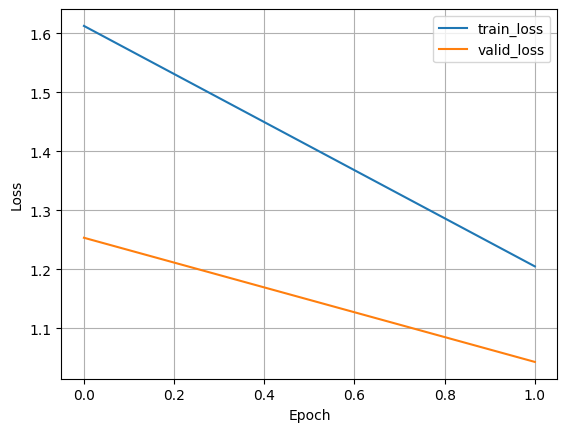

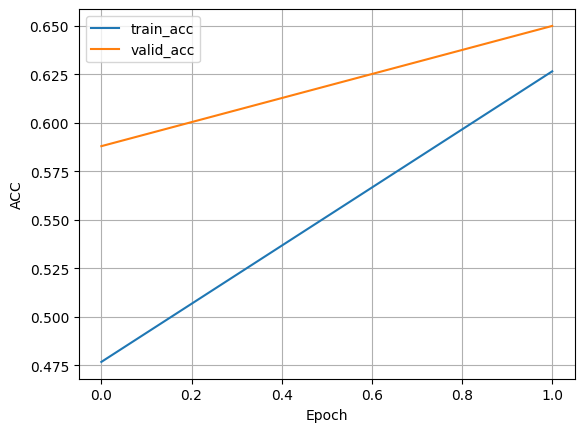

In [15]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

# print(aggreg_metrics)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

## Evaluamos el mejor modelo en el grupo de test

In [16]:
trainer.test(model = pytorch_model, datamodule = data_module, ckpt_path = 'best') # cargamos el mejor checkpoint del modelo

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /home/eaguayo/workspace/DeepLearning/taller1/checkpoints/best_model-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /home/eaguayo/workspace/DeepLearning/taller1/checkpoints/best_model-v1.ckpt


DEBUG: Forzando el tamaño del conjunto de datos en setup.
Muestras de entrenamiento: 5000
Muestras de validación: 1000
Muestras de evaluación: 10000


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5687000155448914     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.5687000155448914}]